In [2]:
import os
import numpy as np
import librosa
import librosa.display
import adabound
from models import *
from Testing import *
# from 

/media/sdb1/hy17/venv/lib/python3.6/site-packages/numba/errors.py:131: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [3]:
#def data_Loading():    
timitTrPath='/media/sdc1/Data/timit-wav/train'
timitTePath='/media/sdc1/Data/timit-wav/test'
allTrSpkrPath=[] # #462
allTeSpkrPath=[] # #168
for dr in range(8):
    rootPath=timitTrPath+'/dr{}'.format(dr+1)
    allTrSpkrPath+= [os.path.join(rootPath,spkr) for spkr in os.listdir(rootPath) if os.path.isdir(os.path.join(rootPath, spkr))]
    rootPath=timitTePath+'/dr{}'.format(dr+1)
    allTeSpkrPath+= [os.path.join(rootPath,spkr) for spkr in os.listdir(rootPath) if os.path.isdir(os.path.join(rootPath, spkr))]


np.random.seed(1)
trSpkrIdx=np.random.permutation(len(allTrSpkrPath))[:100]
teSpkrIdx=np.random.permutation(len(allTeSpkrPath))[:20]

    
np.random.seed(1)
trUttPaths=[] #all wav filepath for train
for i in trSpkrIdx:
    for uttFiles in os.listdir(allTrSpkrPath[i]):
        if uttFiles.endswith('.wav'):
            trUttPaths+=[os.path.join(allTrSpkrPath[i],uttFiles)]


teUttPaths=[] #all wav filepath for test
for i in teSpkrIdx:
    for uttFiles in os.listdir(allTeSpkrPath[i]):
        if uttFiles.endswith('.wav'):
            teUttPaths+=[os.path.join(allTeSpkrPath[i],uttFiles)]
            

In [4]:
# Add Noise
noise_path = "/media/sdc1/Data/Duan/computerkeyboard.wav"
n, nr = librosa.load(noise_path, sr=None)
n /= np.std(n) # make sure equal loudness

trs, tes, trx, tex =[], [], [], []
trX, teX, trY, teY =[], [], [], []
len_n = len(n)
for path in trUttPaths:
    s, sr=librosa.load(path, sr=None)
    s = s/np.std(s)
    length = min(len(s),len_n)
    trs.append(s[:length])
    trx.append(s[:length] + n[:length])

x = len(trs[0])
for i in range(len(trs)):
    x = min(x, len(trs[i]))
trs = [i[:x] for i in trs] # truncate
trx = [i[:x] for i in trx] # truncate
trn = n[:x]

# n = n[:lenth]
# trX.append(20*np.log10(np.abs(librosa.stft(s+n, n_fft=1024, hop_length=256))))
# trY.append(20*np.log10(np.abs(librosa.stft(s, n_fft=1024, hop_length=256))))

for path in teUttPaths:
    s, sr=librosa.load(path, sr=None)
    s = s/np.std(s)
    length = min(len(s),len_n)
    tes.append(s[:length])
    tex.append(s[:length] + n[:length])

x = len(tes[0])
for i in range(len(tes)):
    x = min(x, len(tes[i]))
tes = [i[:x] for i in tes] # truncate
tex = [i[:x] for i in tex] # truncate
ten = n[:x]

maxAmp=0
for signal in trx:
    if np.max(np.abs(signal))>maxAmp:
        maxAmp=np.max(np.abs(signal))

maxAmp*=1.5
# print(maxAmp)
trs/=maxAmp
trn/=maxAmp
trx/=maxAmp
tes/=maxAmp
tex/=maxAmp
ten/=maxAmp

trS, trX, teS, teX, trN, teN=[],[],[],[],[],[]
for signal in trs:
#     trS.append(20*np.log10(np.abs(librosa.stft(signal, n_fft=1024, hop_length=256))))
    trS.append(librosa.stft(signal, n_fft=1024, hop_length=256))
for signal in trx:
    trX.append(librosa.stft(signal, n_fft=1024, hop_length=256))    
for signal in tes:
    teS.append(librosa.stft(signal, n_fft=1024, hop_length=256))
for signal in tex:
    teX.append(librosa.stft(signal, n_fft=1024, hop_length=256))

trN = librosa.stft(trn, n_fft=1024, hop_length=256)
teN = librosa.stft(ten, n_fft=1024, hop_length=256)

# trS -= np.mean(trS)
# trX -= np.mean(trX)
# trY -= np.mean(trY)
# teS -= np.mean(teS)
# teX -= np.mean(teX)
# teY -= np.mean(teY)
# trN -= np.mean(teX)
# teN -= np.mean(teY)

 # Masking
beta=2
trY=[]
for i in range(len(trS)):
    trY.append((np.abs(trS[i])**beta)/(np.abs(trS[i])**beta+np.abs(trN)**beta))

teY=[]
for i in range(len(teS)):
    teY.append((np.abs(teS[i])**beta)/(np.abs(teS[i])**beta+np.abs(teN)**beta))


In [4]:
# plt.imshow(np.array(trN), aspect='auto', origin='lower')
# plt.show()

In [5]:
# plt.imshow(np.array(trS)[10, :, :], aspect='auto', origin='lower')
# plt.show()

In [6]:
# plt.imshow(np.array(trX)[10, :, :], aspect='auto', origin='lower')
# plt.show()

In [7]:
# BATCH = 1
# train_loader = torch.utils.data.DataLoader(trX, batch_size=BATCH)
# train_loader = torch.utils.data.DataLoader(trY, batch_size=BATCH)
# test_loader = torch.utils.data.DataLoader([teX,teY], batch_size=BATCH)

In [8]:
# train_iter = iter(train_loader)
# train=train_iter.next()
# len(train[0].shape)

In [ ]:
Class Processed_data(Dataset):
    

In [24]:
def SDR_(s,sr): # s - original input; sr --  cleaned one
    eps=1e-20
    ml=np.minimum(len(s), len(sr))
    s=s[:ml]
    sr=sr[:ml]
    return ml, 10*np.log10(np.sum(s**2)/(np.sum((s-sr)**2)+eps)+eps)

def SIR_(s,sr): # s - original input; sr --  cleaned one
    eps=1e-20
    ml=np.minimum(len(s), len(sr))
    s=s[:ml]
    sr=sr[:ml]
    return ml, 10*np.log10(np.sum(s**2)/(np.sum((s-sr)**2)+eps)+eps)

def SAR_(s,sr): # s - original input; sr --  cleaned one
    eps=1e-20
    ml=np.minimum(len(s), len(sr))
    s=s[:ml]
    sr=sr[:ml]
    return ml, 10*np.log10(np.sum(s**2)/(np.sum((s-sr)**2)+eps)+eps)

def Ada_test(model):
    model.eval()
    ml=np.zeros(len(teX))
    SDRlist=np.zeros(len(teX))
    err=0.
    bs = 10
    for i in range(0,len(teX),bs):     
        
        data = Variable(torch.cuda.FloatTensor(np.transpose(20*np.log10(np.abs(np.asarray(teX[i:i+bs]))), (2,0,1))),requires_grad=False)
        # data.shape == [513,N]
        x_ = np.transpose(np.asarray(teX[i:i+bs])) # tex.shape == [N,513]
#         print(x_.shape) == [89,513,1]
        pe_mask = model.forward(data)  #teYh

        p_source = np.transpose(x_[:,:,0]*np.float32(pe_mask.data.cpu().numpy()))
#         print(p_source.shape)
        tesr=librosa.istft(p_source, hop_length=256)

        ml[i], SDRlist[i]=SDR_(tes[i], tesr)
#           print(SDRlist[i])
        
    return err, np.sum(ml*SDRlist/np.sum(ml))

In [25]:
def run_model(opt):
    bs=1
    eps=1e-20
    model=plain_cnn().cuda()

    if opt == 'Adam':
        optimizer= torch.optim.Adam(model.parameters(), lr=0.001)#, betas=[0.9, 0.999])
    if opt == 'AdaBound':
        optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=0.1)
    if opt == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    if opt == 'Adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=0.001)

#     run(opt, model)
    
    print('Start running', opt)
    te_sdr = []
    tr_sdr = []
    errt=np.zeros(maxEpoch, dtype=np.float32)
    loss_function= nn.MSELoss()
    bs = 1
    for epoch in range(maxEpoch):    
        if epoch%10 == 0:
            print('running on epoch',epoch)
        model.train()
        begin_ep = time.time()
        err=0.
        shuffle = np.random.permutation(len(trX))
        sdr_it = np.zeros(len(trX))
        for i in shuffle:

            data = Variable(torch.cuda.FloatTensor(np.transpose(20*np.log10(np.abs(np.asarray(trX[i:i+bs]))), (2,0,1))), requires_grad=False)
                # data.shape == [64, 1, 513]
            x_ = np.transpose(np.asarray(trX[i:i+bs])) # tex.shape == [N,513]    
            t_mask = Variable(torch.cuda.FloatTensor(np.array(trY[i:i+bs])), requires_grad=False) #mbY
            t_mask = t_mask[0].transpose(0,1)
    #         print(t_mask.shape) == [64,513]

            p_mask=model.forward(data)  
            err = loss_function(t_mask, p_mask)    
            errt[epoch]+=err.data.cpu().numpy()

            optimizer.zero_grad()
            err.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(),.0001)
            optimizer.step()

        print('ep: {}\t train error: {}'.format(epoch, errt[epoch]))
        tr_sdr.append(np.mean(sdr_it))

        _, sdr = Ada_test(model) # test
        print(sdr)
        te_sdr.append(sdr)

#     np.save(opt+'2tr_sdr.npy', tr_sdr)
#     np.save(opt+'2te_sdr.npy', te_sdr)
#     np.save(opt+'2tr_err.npy', errt)
    #     np.save('epoch_non_uni.npy', epoch_l)


In [24]:
# maxEpoch=50
# run_model('SGD')
# run_model('Adam')  #
# run_model('Adagrad')  #
# run_model('AdaBound')  #

Start running SGD
running on epoch 0
ep: 0	 train error: 103.5322265625
ep: 1	 train error: 69.38208770751953
ep: 2	 train error: 66.14752197265625
ep: 3	 train error: 64.34466552734375
ep: 4	 train error: 62.95957946777344
ep: 5	 train error: 61.74244689941406
ep: 6	 train error: 60.69642639160156
ep: 7	 train error: 59.67334747314453
ep: 8	 train error: 58.56842803955078
ep: 9	 train error: 57.50328063964844
running on epoch 10
ep: 10	 train error: 56.376163482666016
ep: 11	 train error: 55.27201461791992
ep: 12	 train error: 54.19951629638672
ep: 13	 train error: 53.130306243896484
ep: 14	 train error: 52.053985595703125
ep: 15	 train error: 51.06150436401367
ep: 16	 train error: 50.10080337524414
ep: 17	 train error: 49.291038513183594
ep: 18	 train error: 48.47819900512695
ep: 19	 train error: 47.6876106262207
running on epoch 20
ep: 20	 train error: 47.029109954833984
ep: 21	 train error: 46.238243103027344
ep: 22	 train error: 45.497440338134766
ep: 23	 train error: 44.776893615

In [26]:
maxEpoch=50
run_model('Adam')  #
# run_model('Adagrad')  #

Start running Adam
running on epoch 0


/media/sdb1/hy17/venv/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([640, 513])) that is different to the input size (torch.Size([64, 513])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (64) must match the size of tensor b (640) at non-singleton dimension 0

In [ ]:
plt.imshow(data.detach().cpu().numpy()[:,0,:].T, aspect='auto', origin='lower')
plt.show()

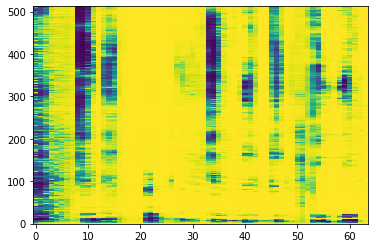

In [66]:
plt.imshow(p_mask.detach().cpu().numpy().T, aspect='auto', origin='lower')
plt.show()

In [40]:
20%10

0

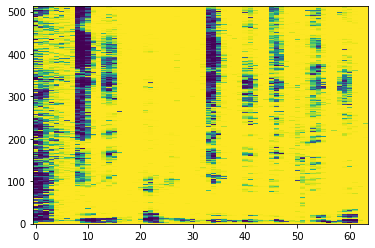

In [8]:
plt.imshow(trY[0], aspect='auto', origin='lower')
plt.show()

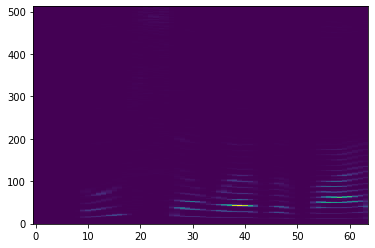

In [16]:
plt.imshow(np.abs(trS[0]), aspect='auto', origin='lower')
plt.show()

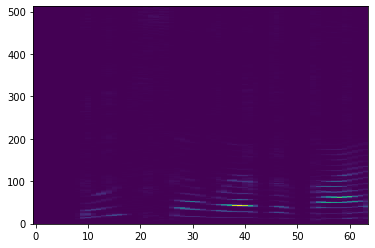

In [10]:
plt.imshow(np.abs(trX[0]*trY[0], aspect='auto', origin='lower')
plt.show()

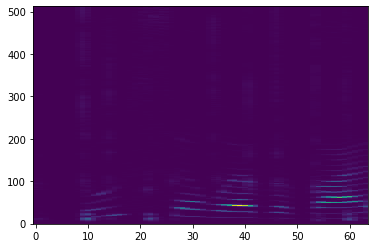

In [8]:
plt.imshow(trX[0], aspect='auto', origin='lower')
plt.show()

In [48]:
trY[0]

array([[0.19339785, 0.18884027, 0.10892628, ..., 0.09716747, 0.12863836,
        0.07102084],
       [0.2661194 , 0.2155954 , 0.20174836, ..., 0.18036547, 0.11382609,
        0.07244773],
       [0.48633933, 0.35237557, 0.19219041, ..., 0.40730464, 0.1975793 ,
        0.06661647],
       ...,
       [0.77165955, 0.57819355, 0.65613323, ..., 0.16814488, 0.13017185,
        0.13441   ],
       [0.4977941 , 0.53474844, 0.5758637 , ..., 0.16273792, 0.18936953,
        0.15161327],
       [0.26361164, 0.46538034, 0.6665501 , ..., 0.1614113 , 0.12933348,
        0.16559267]], dtype=float32)

In [8]:
p_source = trX[0]*p_mask.detach().cpu().numpy().T
print(p_source.shape)
trsr=librosa.istft(p_source, hop_length=256)

_, S=SDR_(trs[0], trsr)

(513, 64)


In [9]:
S

13.064371385229116